In [33]:
import torch
import sys
sys.path.append('../')
from DataType.ElectricField import ElectricField
from LightSource.PlaneWave import PlaneWave
from Props.ASM_Prop import ASM_prop
from Props.RSC_Prop import RSC_prop
from Components.Thin_Lens import Thin_LensElement
from Components.Aperture import ApertureElement
from Components.QuantizedDOE import SoftGumbelQuantizedDOELayerv3 as SoftGumbelQuantizedDOELayer
from Components.QuantizedDOE import FullPrecisionDOELayer
from Components.QuantizedDOE import FixDOEElement
from Addons.Field_Crop import Field_Cropper
from utils.units import *
import numpy as np
import scipy.io
import time
import torch.nn as nn

In [34]:
# DOE parameters
epsilon = 1.6**2
tand = 0

wavelength = 530 * nm


input_field_shape = [1024, 1024]
input_dxy = 8 * um
doe_shape = [512, 512]
doe_dxy = 16 * um

crop_size = 512
#print("The number of wavelengths: " +  str(wavelengths.shape[0]))

# all parameters of DOE optimization
doe_params = {
    'doe_size': doe_shape,
    'doe_dxy' : doe_dxy,
    'doe_level': 2**3,
    'look_up_table': None,
    'num_unit': None,
    'height_constraint_max': 2*um,
    'tolerance': 0,  
    'material': [epsilon, tand]
}

optim_params = {
    'c_s': 100,   # a number to boost the score (higher more robust to gumbel noise)
    'tau_max': 2.5, # maximum value of tau
    'tau_min': 1.5  # minimum value of tau
}

torch.Size([1, 1, 200, 200])


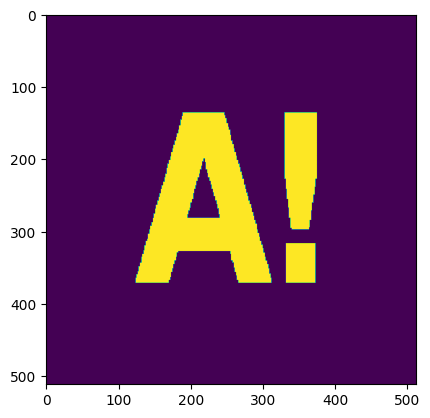

In [35]:
import numpy as np
from PIL import Image
from utils.Helper_Functions import normalize
import matplotlib.pyplot as plt
import torch.nn.functional as F
# choose the recon amp 
im = np.array(Image.open('./Aalto-logo2.png').convert('L'))
target1 = torch.tensor(im, dtype=torch.float).unsqueeze(0).unsqueeze(0)
target1 = normalize(target1)
print(target1.shape)
target1 = F.pad(input=target1, pad=(60, 60, 60, 60), mode='constant', value=0)
target1 = nn.functional.interpolate(torch.round(target1), size=[crop_size, crop_size])
plt.imshow(target1[0,0,:,:])

## 2. Define the System with FullPrecisionDOE

In [36]:
class DOEsystem(nn.Module):
    """ simulate a simple system with one diffractive optical element 
    """
    def __init__(self, 
                 input_dxy, 
                 input_field_shape,
                 doe_params, 
                 optim_params,
                 wavelengths):
        super().__init__()

        self.source = PlaneWave(height=input_field_shape[0],
                                width=input_field_shape[1],
                                spacing=input_dxy,
                                wavelengths=wavelengths)

        self.aperture = ApertureElement(aperture_type = 'rect',
                                        aperture_size = input_field_shape[0] * input_dxy / 2)

        self.doe = FullPrecisionDOELayer(doe_params)

        self.asm_prop = ASM_prop(z_distance=100 * mm, 
                                 bandlimit_type='exact', 
                                 padding_scale=2, 
                                 bandlimit_kernel=True)

        self.field_crop = Field_Cropper(outputHeight=512,outputWidth=512)

    def forward(self, iter_frac):

        output_field = self.asm_prop(
            self.doe(
                self.aperture(
                    self.source()
                )
            )
        )

        
        return self.field_crop(output_field)

In [37]:
setup = DOEsystem(input_dxy=input_dxy, 
                  input_field_shape=input_field_shape, 
                  doe_params=doe_params, 
                  optim_params=optim_params,
                  wavelengths=wavelength)

In [38]:
max_itrs = 10000

losses = []
itr_list = []
itr_to_save_plots = []
setup.cuda()
target1 = target1.cuda()
optimizer = torch.optim.Adam(setup.parameters(), lr=2e-3)

loss_fn = nn.MSELoss()

best_loss = 10

for itr in range(max_itrs):
    field = setup.forward(iter_frac=itr/max_itrs)
    out_amp = normalize(torch.abs(field.data)**2)
    loss = loss_fn(out_amp, target1)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.item())
    itr_list.append(itr)
    
    if itr % 200 == 0 or itr == (max_itrs-1):
        print("The iteration : {}, Loss: {}".format(itr, loss))
        #out_field_1.visualize(flag_axis = True, figsize=(6,6), wavelength=wavelengths, intensity=True)
        #out_field_2.visualize(flag_axis = True, figsize=(6,6), wavelength=wavelengths, intensity=True)
    
    if loss < best_loss:
        best_setup = setup
        best_loss = loss
        best_field = field

The critical distance is [0.3707549] m, the TF will be fine during the sampling !
The iteration : 0, Loss: 0.11222939193248749
The iteration : 200, Loss: 0.09055575728416443
The iteration : 400, Loss: 0.08349911868572235
The iteration : 600, Loss: 0.07870609313249588
The iteration : 800, Loss: 0.07510176301002502
The iteration : 1000, Loss: 0.07209726423025131
The iteration : 1200, Loss: 0.06942440569400787
The iteration : 1400, Loss: 0.06728064268827438
The iteration : 1600, Loss: 0.06555693596601486
The iteration : 1800, Loss: 0.06376612186431885
The iteration : 2000, Loss: 0.06215738132596016
The iteration : 2200, Loss: 0.06077089160680771
The iteration : 2400, Loss: 0.059549637138843536
The iteration : 2600, Loss: 0.058272913098335266
The iteration : 2800, Loss: 0.05710054934024811
The iteration : 3000, Loss: 0.056077782064676285
The iteration : 3200, Loss: 0.055218406021595
The iteration : 3400, Loss: 0.05433445796370506
The iteration : 3600, Loss: 0.05324455723166466
The iteratio

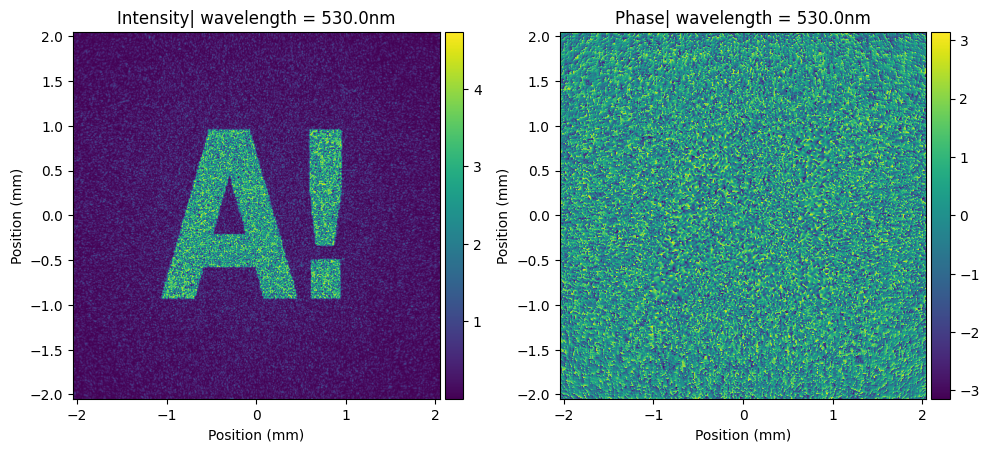

In [39]:
best_field.visualize(flag_axis = True, figsize=(10,10), wavelength=wavelength, intensity=True)

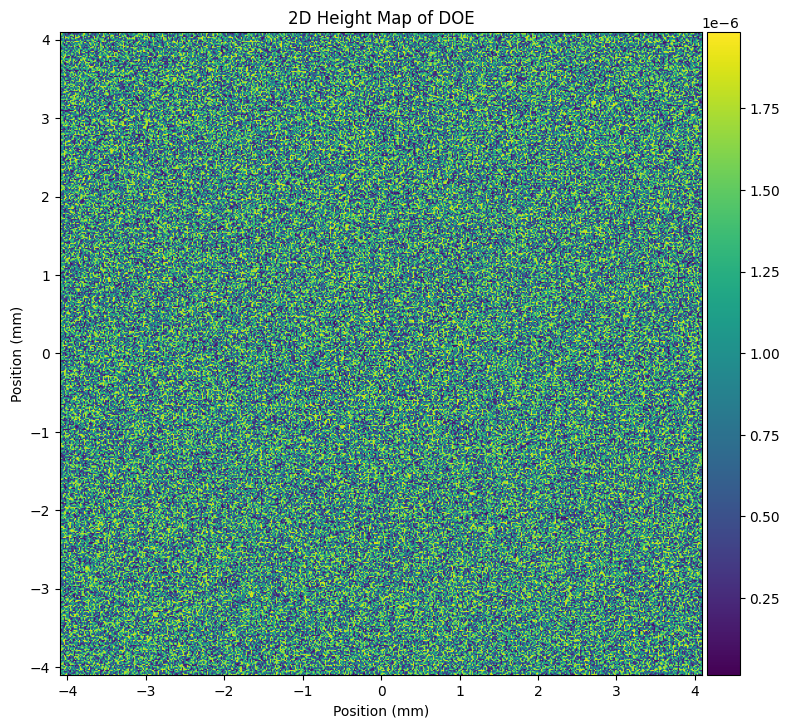

In [40]:
best_setup.doe.visualize(figsize=(8,8), crop_size=[crop_size, crop_size])

## 3. Define the System with Quantized DOE

In [53]:
class DOEsystem(nn.Module):
    """ simulate a simple system with one diffractive optical element 
    """
    def __init__(self, 
                 input_dxy, 
                 input_field_shape,
                 doe_params, 
                 optim_params,
                 wavelengths):
        super().__init__()

        self.source = PlaneWave(height=input_field_shape[0],
                                width=input_field_shape[1],
                                spacing=input_dxy,
                                wavelengths=wavelengths)

        self.aperture = ApertureElement(aperture_type = 'rect',
                                        aperture_size = input_field_shape[0] * input_dxy / 2)

        self.doe = SoftGumbelQuantizedDOELayer(doe_params, optim_params)

        self.asm_prop = ASM_prop(z_distance=100 * mm, 
                                 bandlimit_type='exact', 
                                 padding_scale=2, 
                                 bandlimit_kernel=True)

        self.field_crop = Field_Cropper(outputHeight=512,outputWidth=512)

    def forward(self, iter_frac):

        output_field = self.asm_prop(
            self.doe(
                self.aperture(
                    self.source()
                )
            , iter_frac)
        )

        
        return self.field_crop(output_field)

In [54]:
setup = DOEsystem(input_dxy=input_dxy, 
                  input_field_shape=input_field_shape, 
                  doe_params=doe_params, 
                  optim_params=optim_params,
                  wavelengths=wavelength)

max_itrs = 10000

losses = []
itr_list = []
itr_to_save_plots = []
setup.cuda()
target1 = target1.cuda()
optimizer = torch.optim.AdamW(setup.parameters(), lr=2e-3)

loss_fn = nn.MSELoss()

best_loss = 10

for itr in range(max_itrs):
    field = setup.forward(iter_frac=itr/max_itrs)
    out_amp = normalize(torch.abs(field.data)**2)
    loss = loss_fn(out_amp, target1)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.item())
    itr_list.append(itr)
    
    if itr % 200 == 0 or itr == (max_itrs-1):
        print("The iteration : {}, Loss: {}".format(itr, loss))
        #out_field_1.visualize(flag_axis = True, figsize=(6,6), wavelength=wavelengths, intensity=True)
        #out_field_2.visualize(flag_axis = True, figsize=(6,6), wavelength=wavelengths, intensity=True)
    
    if loss < best_loss:
        best_setup = setup
        best_loss = loss
        best_field = field

The critical distance is [0.3707549] m, the TF will be fine during the sampling !
The iteration : 0, Loss: 0.11114664375782013
The iteration : 200, Loss: 0.10744965076446533
The iteration : 400, Loss: 0.10282563418149948
The iteration : 600, Loss: 0.09845013171434402
The iteration : 800, Loss: 0.09509330987930298
The iteration : 1000, Loss: 0.09252716600894928
The iteration : 1200, Loss: 0.09046255052089691
The iteration : 1400, Loss: 0.08874577283859253
The iteration : 1600, Loss: 0.08726118505001068
The iteration : 1800, Loss: 0.08594676852226257
The iteration : 2000, Loss: 0.08476674556732178
The iteration : 2200, Loss: 0.08369410037994385
The iteration : 2400, Loss: 0.08270397782325745
The iteration : 2600, Loss: 0.08178611844778061
The iteration : 2800, Loss: 0.08093473315238953
The iteration : 3000, Loss: 0.08013129979372025
The iteration : 3200, Loss: 0.08514994382858276
The iteration : 3400, Loss: 0.08999276161193848
The iteration : 3600, Loss: 0.09694589674472809
The iteration

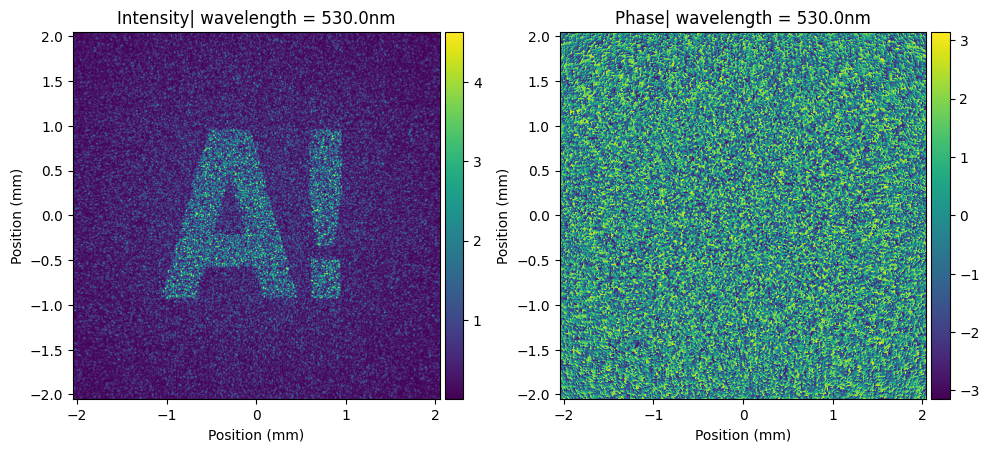

In [55]:
best_field.visualize(flag_axis = True, figsize=(10,10), wavelength=wavelength, intensity=True)

In [ ]:
best_setup.doe.visualize(figsize=(8,8), crop_size=[crop_size, crop_size])

In [ ]:
best_setup.doe.height_map.unique()